# Doodle Recognition with Prototypical Networks

This notebook implements **Prototypical Networks** for doodle recognition - a powerful few-shot learning approach that's fundamentally different from both standard classification and Siamese networks.

## Key Concepts:
- **Episode-based training**: Each training episode simulates a few-shot task
- **Class Prototypes**: Computes the mean embedding of support examples for each class
- **Distance-based classification**: Query images classified by distance to prototypes
- **Meta-learning**: Learns to learn from few examples

## How It Differs from Other Approaches:

| Approach | Training | Classification | Key Idea |
|----------|----------|----------------|----------|
| **Standard CNN** | All classes at once | Softmax over fixed classes | Learn decision boundaries |
| **Siamese Network** | Pairs (similar/dissimilar) | Compare to references | Learn similarity function |
| **Prototypical Network** | Episodes (N-way K-shot) | Distance to prototypes | Learn metric space |

## Paper Reference:
Snell, Swersky, and Zemel (2017) - "Prototypical Networks for Few-shot Learning"


In [32]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from PIL import Image
import warnings
import random
from collections import defaultdict
import json
warnings.filterwarnings('ignore')

# PyTorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Sampler
import torchvision.transforms as transforms
from torchvision import models

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    print("MPS (Apple Silicon) available: True")
else:
    print("Using CPU")


PyTorch version: 2.9.1
CUDA available: False
MPS (Apple Silicon) available: True


In [33]:
# Setup device (GPU/MPS/CPU)
def setup_device():
    """Setup device for training (CUDA/MPS/CPU)"""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"✓ Using CUDA: {torch.cuda.get_device_name(0)}")
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device = torch.device('mps')
        print("✓ Using MPS (Apple Silicon)")
    else:
        device = torch.device('cpu')
        print("⚠ Using CPU")
    return device

device = setup_device()


✓ Using MPS (Apple Silicon)


## 1. Configuration


In [34]:
# Configuration
IMG_SIZE = 84  # Common size for few-shot learning benchmarks
EMBEDDING_DIM = 64  # Output dimension of the embedding network

# Episode configuration
N_WAY = 5  # Number of classes per episode
K_SHOT = 5  # Number of support examples per class
Q_QUERY = 15  # Number of query examples per class

# Training configuration
TRAIN_EPISODES = 1000  # Episodes per epoch
VAL_EPISODES = 200  # Episodes for validation
NUM_EPOCHS = 30
LEARNING_RATE = 1e-3

# Data configuration
MAX_CATEGORIES = 60  # Use subset for faster training (None = all)
IMAGES_PER_CATEGORY = 600  # Images per category

# Distance metric
DISTANCE = 'euclidean'  # 'euclidean' or 'cosine'

print(f"Configuration:")
print(f"  Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Embedding dimension: {EMBEDDING_DIM}")
print(f"  Episode: {N_WAY}-way {K_SHOT}-shot with {Q_QUERY} queries")
print(f"  Training episodes per epoch: {TRAIN_EPISODES}")
print(f"  Distance metric: {DISTANCE}")


Configuration:
  Image size: 84x84
  Embedding dimension: 64
  Episode: 5-way 5-shot with 15 queries
  Training episodes per epoch: 1000
  Distance metric: euclidean


## 2. Data Loading


In [35]:
def load_data_by_category(base_dir, max_categories=None, max_per_category=None):
    """
    Load image paths organized by category for Prototypical Network training.
    
    Returns:
        category_images: dict mapping category name -> list of image paths
        categories: list of category names
    """
    base_path = Path(base_dir)
    all_categories = sorted([d.name for d in base_path.iterdir() if d.is_dir()])
    
    if max_categories:
        categories = all_categories[:max_categories]
    else:
        categories = all_categories
    
    print(f"Loading data from {len(categories)} categories...")
    
    category_images = {}
    total_images = 0
    
    for category in tqdm(categories, desc="Loading categories"):
        category_path = base_path / category
        if not category_path.exists():
            continue
        
        png_files = list(category_path.glob('*.png'))
        if max_per_category:
            random.shuffle(png_files)  # Shuffle to get varied samples
            png_files = png_files[:max_per_category]
        
        # Verify images are valid
        valid_files = []
        for f in png_files:
            try:
                with Image.open(f) as img:
                    img.verify()
                valid_files.append(str(f))
            except:
                pass
        
        # Need at least K_SHOT + Q_QUERY images per category
        min_required = K_SHOT + Q_QUERY
        if len(valid_files) >= min_required:
            category_images[category] = valid_files
            total_images += len(valid_files)
    
    print(f"\nLoaded {total_images} images from {len(category_images)} categories")
    print(f"Minimum images per category: {min(len(v) for v in category_images.values())}")
    print(f"Maximum images per category: {max(len(v) for v in category_images.values())}")
    return category_images, list(category_images.keys())

# Load data
category_images, categories = load_data_by_category(
    'doodles/doodle',
    max_categories=MAX_CATEGORIES,
    max_per_category=IMAGES_PER_CATEGORY
)

print(f"\nCategories loaded: {categories[:10]}...")
print(f"Sample counts: {[len(category_images[c]) for c in categories[:5]]}")


Loading data from 60 categories...


Loading categories: 100%|██████████| 60/60 [00:06<00:00,  9.99it/s]


Loaded 36000 images from 60 categories
Minimum images per category: 600
Maximum images per category: 600

Categories loaded: ['The Eiffel Tower', 'The Great Wall of China', 'The Mona Lisa', 'airplane', 'alarm clock', 'ambulance', 'angel', 'animal migration', 'ant', 'anvil']...
Sample counts: [600, 600, 600, 600, 600]


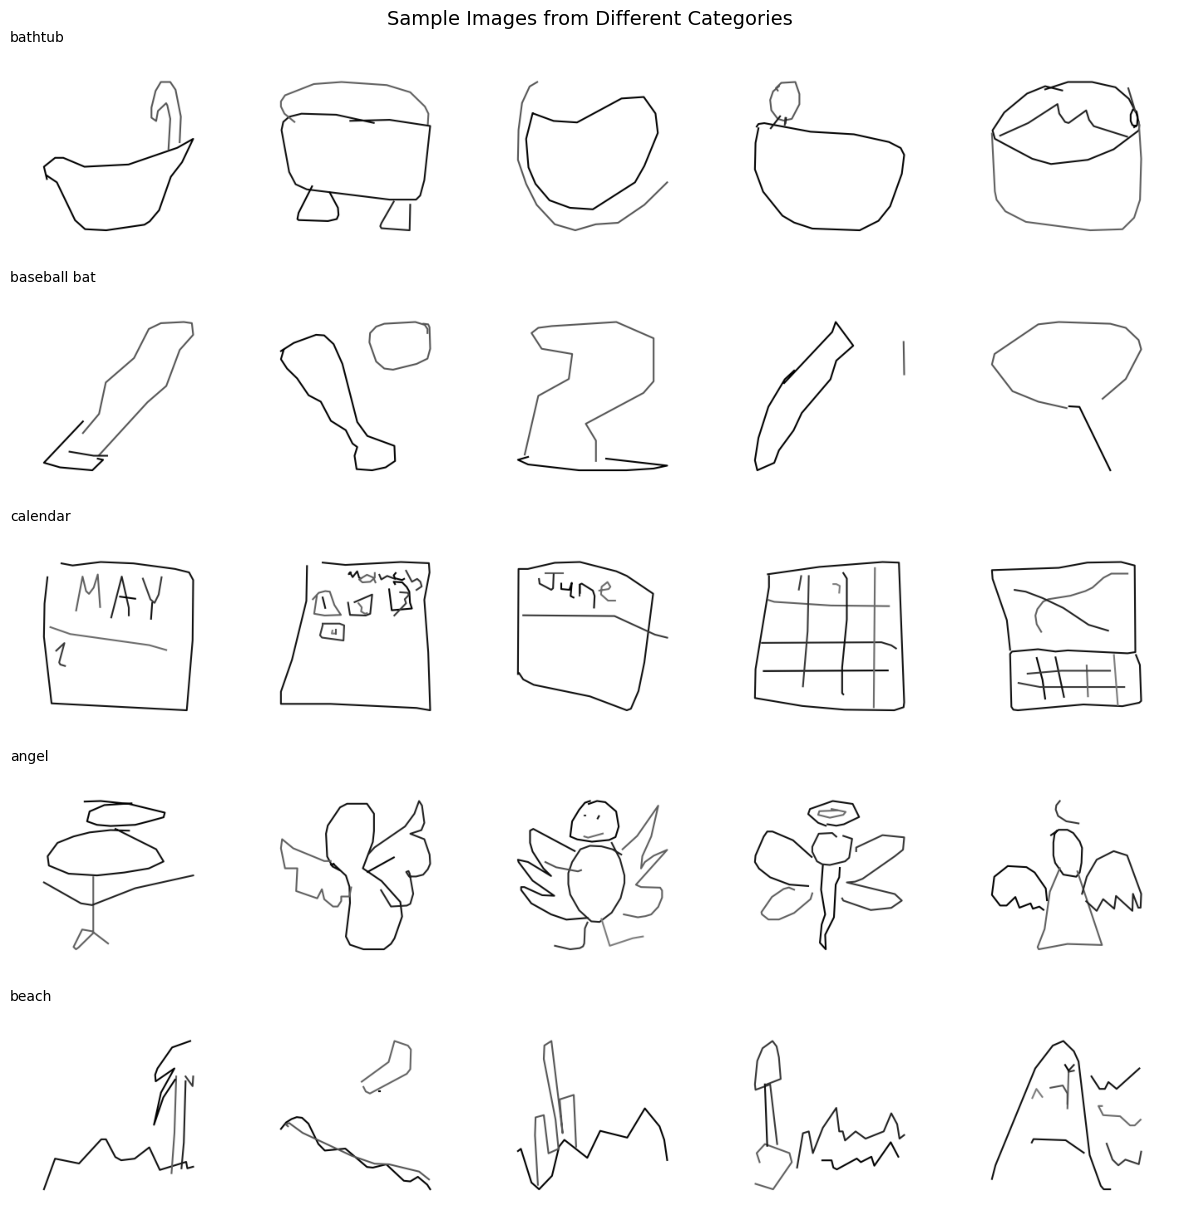

In [36]:
# Visualize sample images from different categories
def visualize_categories(category_images, categories, n_categories=5, n_images=5):
    """Visualize sample images from multiple categories"""
    fig, axes = plt.subplots(n_categories, n_images, figsize=(12, n_categories * 2.5))
    
    sample_cats = random.sample(categories, n_categories)
    
    for i, cat in enumerate(sample_cats):
        sample_images = random.sample(category_images[cat], n_images)
        for j, img_path in enumerate(sample_images):
            img = Image.open(img_path)
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(cat, fontsize=10, loc='left')
    
    plt.suptitle('Sample Images from Different Categories', fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_categories(category_images, categories)


## 3. Episode-based Dataset

Prototypical Networks use **episodic training** where each episode is a mini few-shot task:
- Sample N classes
- For each class, sample K support images and Q query images
- The model must classify queries based only on support examples


In [37]:
# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

print("Transforms defined.")


Transforms defined.


In [38]:
class PrototypicalDataset(Dataset):
    """
    Dataset for Prototypical Network training.
    Returns single images that will be batched into episodes by the sampler.
    """
    def __init__(self, category_images, categories, transform=None):
        self.category_images = category_images
        self.categories = categories
        self.transform = transform
        
        # Create flat list of (image_path, category_idx)
        self.samples = []
        self.category_to_idx = {cat: idx for idx, cat in enumerate(categories)}
        
        for cat in categories:
            cat_idx = self.category_to_idx[cat]
            for img_path in category_images[cat]:
                self.samples.append((img_path, cat_idx))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('L')
        
        if self.transform:
            img = self.transform(img)
        
        return img, label


class EpisodeSampler(Sampler):
    """
    Sampler that generates episodes for Prototypical Network training.
    
    Each episode consists of:
    - N_WAY classes
    - K_SHOT support samples per class
    - Q_QUERY query samples per class
    """
    def __init__(self, category_images, categories, n_way, k_shot, q_query, n_episodes):
        self.category_images = category_images
        self.categories = categories
        self.n_way = n_way
        self.k_shot = k_shot
        self.q_query = q_query
        self.n_episodes = n_episodes
        
        # Build indices for each category
        self.category_indices = defaultdict(list)
        idx = 0
        for cat in categories:
            for _ in category_images[cat]:
                self.category_indices[cat].append(idx)
                idx += 1
    
    def __iter__(self):
        for _ in range(self.n_episodes):
            # Sample N classes
            episode_classes = random.sample(self.categories, self.n_way)
            
            batch_indices = []
            for cat in episode_classes:
                # Sample K+Q images for this class
                available = self.category_indices[cat]
                selected = random.sample(available, self.k_shot + self.q_query)
                batch_indices.extend(selected)
            
            yield batch_indices
    
    def __len__(self):
        return self.n_episodes

print("PrototypicalDataset and EpisodeSampler defined.")


PrototypicalDataset and EpisodeSampler defined.


In [39]:
# Split categories into train/val/test (meta-split)
# Important: we split by CATEGORY, not by image!
train_categories, temp_categories = train_test_split(
    categories, test_size=0.3, random_state=SEED
)
val_categories, test_categories = train_test_split(
    temp_categories, test_size=0.5, random_state=SEED
)

print(f"Train categories: {len(train_categories)}")
print(f"Validation categories: {len(val_categories)}")
print(f"Test categories: {len(test_categories)}")
print(f"\n⚠ Note: Categories are DISJOINT between splits!")
print(f"   This tests true few-shot generalization to new classes.")

# Create category_images dicts for each split
train_category_images = {k: v for k, v in category_images.items() if k in train_categories}
val_category_images = {k: v for k, v in category_images.items() if k in val_categories}
test_category_images = {k: v for k, v in category_images.items() if k in test_categories}

print(f"\nTrain images: {sum(len(v) for v in train_category_images.values())}")
print(f"Val images: {sum(len(v) for v in val_category_images.values())}")
print(f"Test images: {sum(len(v) for v in test_category_images.values())}")


Train categories: 42
Validation categories: 9
Test categories: 9

⚠ Note: Categories are DISJOINT between splits!
   This tests true few-shot generalization to new classes.

Train images: 25200
Val images: 5400
Test images: 5400


In [40]:
# Create datasets
train_dataset = PrototypicalDataset(
    train_category_images, train_categories, transform=train_transform
)
val_dataset = PrototypicalDataset(
    val_category_images, val_categories, transform=val_transform
)
test_dataset = PrototypicalDataset(
    test_category_images, test_categories, transform=val_transform
)

# Create episode samplers
train_sampler = EpisodeSampler(
    train_category_images, train_categories,
    n_way=N_WAY, k_shot=K_SHOT, q_query=Q_QUERY,
    n_episodes=TRAIN_EPISODES
)
val_sampler = EpisodeSampler(
    val_category_images, val_categories,
    n_way=N_WAY, k_shot=K_SHOT, q_query=Q_QUERY,
    n_episodes=VAL_EPISODES
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_sampler=train_sampler,
    num_workers=0
)
val_loader = DataLoader(
    val_dataset,
    batch_sampler=val_sampler,
    num_workers=0
)

print(f"Train episodes per epoch: {len(train_loader)}")
print(f"Val episodes: {len(val_loader)}")
print(f"Batch size per episode: {N_WAY * (K_SHOT + Q_QUERY)}")


Train episodes per epoch: 1000
Val episodes: 200
Batch size per episode: 100


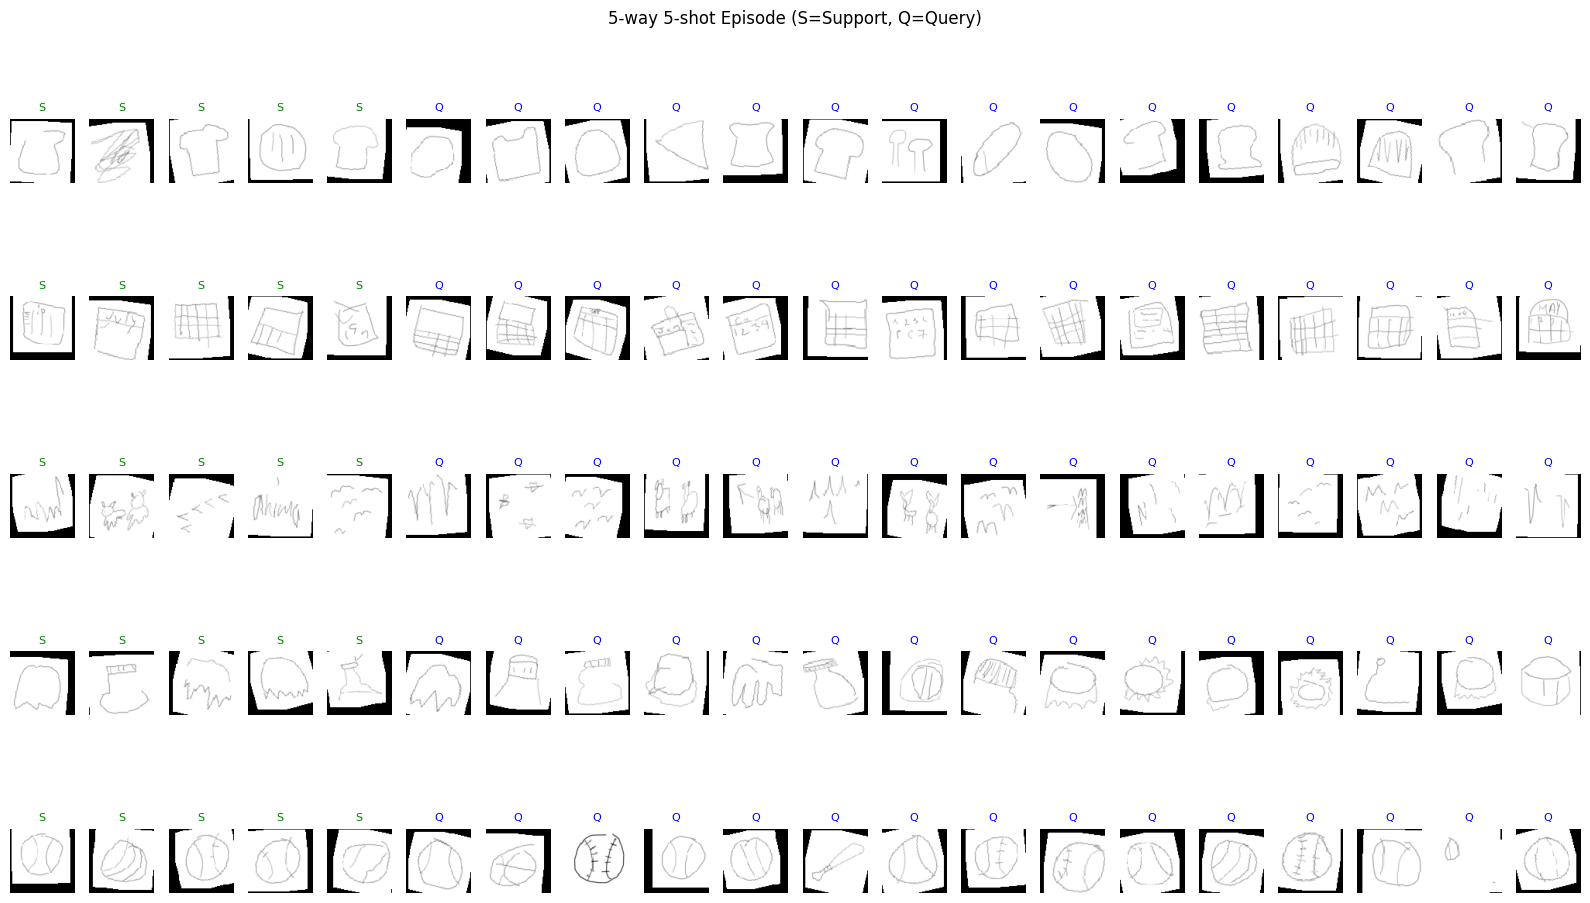

In [41]:
# Visualize an episode
def visualize_episode(batch, n_way=N_WAY, k_shot=K_SHOT, q_query=Q_QUERY):
    """Visualize one episode of training data"""
    images, labels = batch
    
    # Denormalize images
    images = images * 0.5 + 0.5
    
    fig, axes = plt.subplots(n_way, k_shot + q_query, figsize=(16, n_way * 2))
    
    idx = 0
    unique_labels = labels.unique().tolist()
    
    for class_idx in range(n_way):
        for sample_idx in range(k_shot + q_query):
            ax = axes[class_idx, sample_idx]
            img = images[idx].squeeze().numpy()
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            
            # Mark support vs query
            if sample_idx < k_shot:
                ax.set_title('S', color='green', fontsize=8)
            else:
                ax.set_title('Q', color='blue', fontsize=8)
            
            idx += 1
    
    plt.suptitle(f'{n_way}-way {k_shot}-shot Episode (S=Support, Q=Query)', fontsize=12)
    plt.tight_layout()
    plt.show()

# Get one batch and visualize
sample_batch = next(iter(train_loader))
visualize_episode(sample_batch)


## 4. Prototypical Network Architecture

The architecture is a simple CNN encoder that maps images to embeddings.
The key innovation is in the training algorithm, not the architecture.


In [42]:
class ConvBlock(nn.Module):
    """Basic convolutional block: Conv -> BN -> ReLU -> MaxPool"""
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
    
    def forward(self, x):
        return self.block(x)


class ProtoNet(nn.Module):
    """
    Prototypical Network encoder.
    
    Uses a 4-block CNN to produce embeddings, as in the original paper.
    """
    def __init__(self, in_channels=1, hidden_dim=64, embedding_dim=64):
        super(ProtoNet, self).__init__()
        
        self.encoder = nn.Sequential(
            ConvBlock(in_channels, hidden_dim),       # 84 -> 42
            ConvBlock(hidden_dim, hidden_dim),        # 42 -> 21
            ConvBlock(hidden_dim, hidden_dim),        # 21 -> 10
            ConvBlock(hidden_dim, embedding_dim),     # 10 -> 5
        )
        
        # Final spatial size: 5x5 with 64 channels = 1600 features
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(embedding_dim * 5 * 5, embedding_dim)
        )
    
    def forward(self, x):
        """Encode images to embeddings"""
        x = self.encoder(x)
        x = self.fc(x)
        return x


class ProtoNetWithDistance(nn.Module):
    """
    Full Prototypical Network with prototype computation and distance calculation.
    """
    def __init__(self, in_channels=1, hidden_dim=64, embedding_dim=64, distance='euclidean'):
        super(ProtoNetWithDistance, self).__init__()
        self.encoder = ProtoNet(in_channels, hidden_dim, embedding_dim)
        self.distance = distance
    
    def compute_prototypes(self, support_embeddings, n_way, k_shot):
        """
        Compute class prototypes from support embeddings.
        
        Args:
            support_embeddings: [n_way * k_shot, embedding_dim]
            n_way: number of classes
            k_shot: number of support samples per class
            
        Returns:
            prototypes: [n_way, embedding_dim]
        """
        # Reshape to [n_way, k_shot, embedding_dim]
        support_embeddings = support_embeddings.view(n_way, k_shot, -1)
        # Mean across k_shot dimension -> [n_way, embedding_dim]
        prototypes = support_embeddings.mean(dim=1)
        return prototypes
    
    def compute_distances(self, query_embeddings, prototypes):
        """
        Compute distances from query embeddings to prototypes.
        
        Args:
            query_embeddings: [n_query, embedding_dim]
            prototypes: [n_way, embedding_dim]
            
        Returns:
            distances: [n_query, n_way]
        """
        n_query = query_embeddings.size(0)
        n_way = prototypes.size(0)
        
        if self.distance == 'euclidean':
            # Expand dimensions for broadcasting
            # query: [n_query, 1, embedding_dim]
            # proto: [1, n_way, embedding_dim]
            query_expanded = query_embeddings.unsqueeze(1)
            proto_expanded = prototypes.unsqueeze(0)
            
            # Squared Euclidean distance
            distances = torch.sum((query_expanded - proto_expanded) ** 2, dim=2)
        
        elif self.distance == 'cosine':
            # Normalize embeddings
            query_norm = F.normalize(query_embeddings, p=2, dim=1)
            proto_norm = F.normalize(prototypes, p=2, dim=1)
            
            # Cosine similarity (negate to get distance)
            distances = -torch.mm(query_norm, proto_norm.t())
        
        return distances
    
    def forward(self, support_images, query_images, n_way, k_shot):
        """
        Forward pass for an episode.
        
        Args:
            support_images: [n_way * k_shot, C, H, W]
            query_images: [n_way * q_query, C, H, W]
            n_way: number of classes
            k_shot: number of support samples per class
            
        Returns:
            log_probabilities: [n_query, n_way]
        """
        # Encode all images
        support_embeddings = self.encoder(support_images)
        query_embeddings = self.encoder(query_images)
        
        # Compute prototypes
        prototypes = self.compute_prototypes(support_embeddings, n_way, k_shot)
        
        # Compute distances
        distances = self.compute_distances(query_embeddings, prototypes)
        
        # Convert to log probabilities (negative distance -> softmax)
        log_probs = F.log_softmax(-distances, dim=1)
        
        return log_probs
    
    def get_embedding(self, x):
        """Get embedding for inference"""
        return self.encoder(x)


# Initialize model
model = ProtoNetWithDistance(
    in_channels=1,
    hidden_dim=64,
    embedding_dim=EMBEDDING_DIM,
    distance=DISTANCE
).to(device)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


ProtoNetWithDistance(
  (encoder): ProtoNet(
    (encoder): Sequential(
      (0): ConvBlock(
        (block): Sequential(
          (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
      )
      (1): ConvBlock(
        (block): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
      )
      (2): ConvBlock(
        (block): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [43]:
def split_episode_batch(images, labels, n_way, k_shot, q_query):
    """
    Split a batch into support and query sets.
    
    The batch is organized as:
    [class1_support (k_shot), class1_query (q_query), class2_support, class2_query, ...]
    
    Returns:
        support_images, support_labels, query_images, query_labels
    """
    support_images = []
    support_labels = []
    query_images = []
    query_labels = []
    
    idx = 0
    for class_idx in range(n_way):
        # Support set
        support_images.append(images[idx:idx + k_shot])
        support_labels.extend([class_idx] * k_shot)
        idx += k_shot
        
        # Query set
        query_images.append(images[idx:idx + q_query])
        query_labels.extend([class_idx] * q_query)
        idx += q_query
    
    support_images = torch.cat(support_images, dim=0)
    query_images = torch.cat(query_images, dim=0)
    support_labels = torch.tensor(support_labels)
    query_labels = torch.tensor(query_labels)
    
    return support_images, support_labels, query_images, query_labels


def train_epoch(model, train_loader, optimizer, n_way, k_shot, q_query, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    total_acc = 0
    n_episodes = 0
    
    pbar = tqdm(train_loader, desc='Training')
    for images, _ in pbar:
        images = images.to(device)
        
        # Split into support and query
        support_images, _, query_images, query_labels = split_episode_batch(
            images, None, n_way, k_shot, q_query
        )
        query_labels = query_labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        log_probs = model(support_images, query_images, n_way, k_shot)
        
        # Loss
        loss = F.nll_loss(log_probs, query_labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Accuracy
        preds = log_probs.argmax(dim=1)
        acc = (preds == query_labels).float().mean().item()
        
        total_loss += loss.item()
        total_acc += acc
        n_episodes += 1
        
        pbar.set_postfix({'loss': loss.item(), 'acc': f'{acc:.2%}'})
    
    return total_loss / n_episodes, total_acc / n_episodes


def validate(model, val_loader, n_way, k_shot, q_query, device):
    """Validate on validation episodes"""
    model.eval()
    total_loss = 0
    total_acc = 0
    n_episodes = 0
    
    with torch.no_grad():
        for images, _ in tqdm(val_loader, desc='Validation'):
            images = images.to(device)
            
            # Split into support and query
            support_images, _, query_images, query_labels = split_episode_batch(
                images, None, n_way, k_shot, q_query
            )
            query_labels = query_labels.to(device)
            
            # Forward pass
            log_probs = model(support_images, query_images, n_way, k_shot)
            
            # Loss
            loss = F.nll_loss(log_probs, query_labels)
            
            # Accuracy
            preds = log_probs.argmax(dim=1)
            acc = (preds == query_labels).float().mean().item()
            
            total_loss += loss.item()
            total_acc += acc
            n_episodes += 1
    
    return total_loss / n_episodes, total_acc / n_episodes

print("Training functions defined.")


Training functions defined.


## 6. Training


In [44]:
# Optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

print(f"Optimizer: Adam with lr={LEARNING_RATE}")
print(f"Scheduler: StepLR (decay every 10 epochs)")


Optimizer: Adam with lr=0.001
Scheduler: StepLR (decay every 10 epochs)


In [45]:
# Training loop
best_val_acc = 0
train_losses = []
train_accs = []
val_losses = []
val_accs = []

print(f"\nStarting training for {NUM_EPOCHS} epochs...")
print(f"Episode configuration: {N_WAY}-way {K_SHOT}-shot with {Q_QUERY} queries")
print("=" * 60)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    print(f"Learning rate: {scheduler.get_last_lr()[0]:.6f}")
    
    # Regenerate episodes for this epoch
    train_sampler = EpisodeSampler(
        train_category_images, train_categories,
        n_way=N_WAY, k_shot=K_SHOT, q_query=Q_QUERY,
        n_episodes=TRAIN_EPISODES
    )
    train_loader = DataLoader(
        train_dataset,
        batch_sampler=train_sampler,
        num_workers=0
    )
    
    # Train
    train_loss, train_acc = train_epoch(
        model, train_loader, optimizer, N_WAY, K_SHOT, Q_QUERY, device
    )
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validate
    val_sampler = EpisodeSampler(
        val_category_images, val_categories,
        n_way=N_WAY, k_shot=K_SHOT, q_query=Q_QUERY,
        n_episodes=VAL_EPISODES
    )
    val_loader = DataLoader(
        val_dataset,
        batch_sampler=val_sampler,
        num_workers=0
    )
    val_loss, val_acc = validate(model, val_loader, N_WAY, K_SHOT, Q_QUERY, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2%}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2%}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'config': {
                'n_way': N_WAY,
                'k_shot': K_SHOT,
                'embedding_dim': EMBEDDING_DIM,
                'img_size': IMG_SIZE,
                'distance': DISTANCE
            }
        }, 'best_protonet_model.pth')
        print(f"✓ Saved new best model with {val_acc:.2%} validation accuracy")
    
    scheduler.step()

print("\n" + "=" * 60)
print(f"Training complete! Best validation accuracy: {best_val_acc:.2%}")



Starting training for 30 epochs...
Episode configuration: 5-way 5-shot with 15 queries

Epoch 1/30
Learning rate: 0.001000


Validation: 100%|██████████| 200/200 [00:16<00:00, 12.19it/s]


Train Loss: 0.7892 | Train Acc: 71.38%
Val Loss: 0.8388 | Val Acc: 70.66%
✓ Saved new best model with 70.66% validation accuracy

Epoch 2/30
Learning rate: 0.001000


Validation: 100%|██████████| 200/200 [00:14<00:00, 14.27it/s]


Train Loss: 0.5471 | Train Acc: 80.63%
Val Loss: 0.7437 | Val Acc: 74.07%
✓ Saved new best model with 74.07% validation accuracy

Epoch 3/30
Learning rate: 0.001000


Validation: 100%|██████████| 200/200 [00:13<00:00, 15.12it/s]


Train Loss: 0.4664 | Train Acc: 83.51%
Val Loss: 0.6854 | Val Acc: 76.07%
✓ Saved new best model with 76.07% validation accuracy

Epoch 4/30
Learning rate: 0.001000


Validation: 100%|██████████| 200/200 [00:22<00:00,  8.82it/s]


Train Loss: 0.4033 | Train Acc: 85.75%
Val Loss: 0.6455 | Val Acc: 77.17%
✓ Saved new best model with 77.17% validation accuracy

Epoch 5/30
Learning rate: 0.001000


Validation: 100%|██████████| 200/200 [00:12<00:00, 15.78it/s]


Train Loss: 0.3853 | Train Acc: 86.46%
Val Loss: 0.6333 | Val Acc: 78.03%
✓ Saved new best model with 78.03% validation accuracy

Epoch 6/30
Learning rate: 0.001000


Validation: 100%|██████████| 200/200 [00:11<00:00, 16.92it/s]


Train Loss: 0.3458 | Train Acc: 87.98%
Val Loss: 0.5739 | Val Acc: 79.97%
✓ Saved new best model with 79.97% validation accuracy

Epoch 7/30
Learning rate: 0.001000


Validation: 100%|██████████| 200/200 [00:13<00:00, 14.53it/s]


Train Loss: 0.3257 | Train Acc: 88.40%
Val Loss: 0.5977 | Val Acc: 80.91%
✓ Saved new best model with 80.91% validation accuracy

Epoch 8/30
Learning rate: 0.001000


Validation: 100%|██████████| 200/200 [00:13<00:00, 14.75it/s]


Train Loss: 0.3122 | Train Acc: 89.05%
Val Loss: 0.6373 | Val Acc: 77.82%

Epoch 9/30
Learning rate: 0.001000


Validation: 100%|██████████| 200/200 [00:12<00:00, 15.40it/s]


Train Loss: 0.2996 | Train Acc: 89.43%
Val Loss: 0.6473 | Val Acc: 77.77%

Epoch 10/30
Learning rate: 0.001000


Validation: 100%|██████████| 200/200 [00:14<00:00, 13.93it/s]


Train Loss: 0.2848 | Train Acc: 90.11%
Val Loss: 0.5725 | Val Acc: 79.77%

Epoch 11/30
Learning rate: 0.000500


Validation: 100%|██████████| 200/200 [00:14<00:00, 14.07it/s]


Train Loss: 0.2526 | Train Acc: 91.14%
Val Loss: 0.5792 | Val Acc: 79.33%

Epoch 12/30
Learning rate: 0.000500


Validation: 100%|██████████| 200/200 [00:19<00:00, 10.19it/s]


Train Loss: 0.2388 | Train Acc: 91.74%
Val Loss: 0.5733 | Val Acc: 80.65%

Epoch 13/30
Learning rate: 0.000500


Validation: 100%|██████████| 200/200 [00:19<00:00, 10.18it/s]


Train Loss: 0.2381 | Train Acc: 91.66%
Val Loss: 0.5836 | Val Acc: 79.85%

Epoch 14/30
Learning rate: 0.000500


Validation: 100%|██████████| 200/200 [00:14<00:00, 13.60it/s]


Train Loss: 0.2314 | Train Acc: 92.00%
Val Loss: 0.5645 | Val Acc: 79.85%

Epoch 15/30
Learning rate: 0.000500


Validation: 100%|██████████| 200/200 [00:18<00:00, 10.61it/s]


Train Loss: 0.2231 | Train Acc: 92.19%
Val Loss: 0.5828 | Val Acc: 79.49%

Epoch 16/30
Learning rate: 0.000500


Validation: 100%|██████████| 200/200 [00:17<00:00, 11.32it/s]


Train Loss: 0.2231 | Train Acc: 92.19%
Val Loss: 0.6186 | Val Acc: 78.70%

Epoch 17/30
Learning rate: 0.000500


Validation: 100%|██████████| 200/200 [00:12<00:00, 15.69it/s]


Train Loss: 0.2111 | Train Acc: 92.52%
Val Loss: 0.5969 | Val Acc: 78.71%

Epoch 18/30
Learning rate: 0.000500


Validation: 100%|██████████| 200/200 [00:12<00:00, 15.68it/s]


Train Loss: 0.2051 | Train Acc: 92.75%
Val Loss: 0.5743 | Val Acc: 79.77%

Epoch 19/30
Learning rate: 0.000500


Validation: 100%|██████████| 200/200 [00:13<00:00, 15.08it/s]


Train Loss: 0.2066 | Train Acc: 92.65%
Val Loss: 0.6074 | Val Acc: 78.47%

Epoch 20/30
Learning rate: 0.000500


Validation: 100%|██████████| 200/200 [00:14<00:00, 14.05it/s]


Train Loss: 0.2084 | Train Acc: 92.62%
Val Loss: 0.5574 | Val Acc: 80.01%

Epoch 21/30
Learning rate: 0.000250


Validation: 100%|██████████| 200/200 [00:13<00:00, 14.54it/s]


Train Loss: 0.1883 | Train Acc: 93.37%
Val Loss: 0.5742 | Val Acc: 80.39%

Epoch 22/30
Learning rate: 0.000250


Validation: 100%|██████████| 200/200 [00:13<00:00, 14.57it/s]


Train Loss: 0.1843 | Train Acc: 93.50%
Val Loss: 0.6133 | Val Acc: 78.71%

Epoch 23/30
Learning rate: 0.000250


Validation: 100%|██████████| 200/200 [00:18<00:00, 10.63it/s]


Train Loss: 0.1889 | Train Acc: 93.33%
Val Loss: 0.5802 | Val Acc: 80.02%

Epoch 24/30
Learning rate: 0.000250


Validation: 100%|██████████| 200/200 [00:19<00:00, 10.15it/s]


Train Loss: 0.1846 | Train Acc: 93.51%
Val Loss: 0.5757 | Val Acc: 79.73%

Epoch 25/30
Learning rate: 0.000250


Validation: 100%|██████████| 200/200 [00:19<00:00, 10.11it/s]


Train Loss: 0.1813 | Train Acc: 93.58%
Val Loss: 0.5671 | Val Acc: 79.89%

Epoch 26/30
Learning rate: 0.000250


Validation: 100%|██████████| 200/200 [00:13<00:00, 14.43it/s]


Train Loss: 0.1816 | Train Acc: 93.57%
Val Loss: 0.5452 | Val Acc: 80.53%

Epoch 27/30
Learning rate: 0.000250


Validation: 100%|██████████| 200/200 [00:18<00:00, 10.64it/s]


Train Loss: 0.1791 | Train Acc: 93.71%
Val Loss: 0.5765 | Val Acc: 79.61%

Epoch 28/30
Learning rate: 0.000250


Validation: 100%|██████████| 200/200 [00:18<00:00, 10.76it/s]


Train Loss: 0.1783 | Train Acc: 93.64%
Val Loss: 0.5616 | Val Acc: 80.55%

Epoch 29/30
Learning rate: 0.000250


Validation: 100%|██████████| 200/200 [00:18<00:00, 10.87it/s]


Train Loss: 0.1703 | Train Acc: 93.89%
Val Loss: 0.5783 | Val Acc: 79.93%

Epoch 30/30
Learning rate: 0.000250


Validation: 100%|██████████| 200/200 [00:18<00:00, 10.91it/s]

Train Loss: 0.1649 | Train Acc: 94.18%
Val Loss: 0.6303 | Val Acc: 78.53%

Training complete! Best validation accuracy: 80.91%


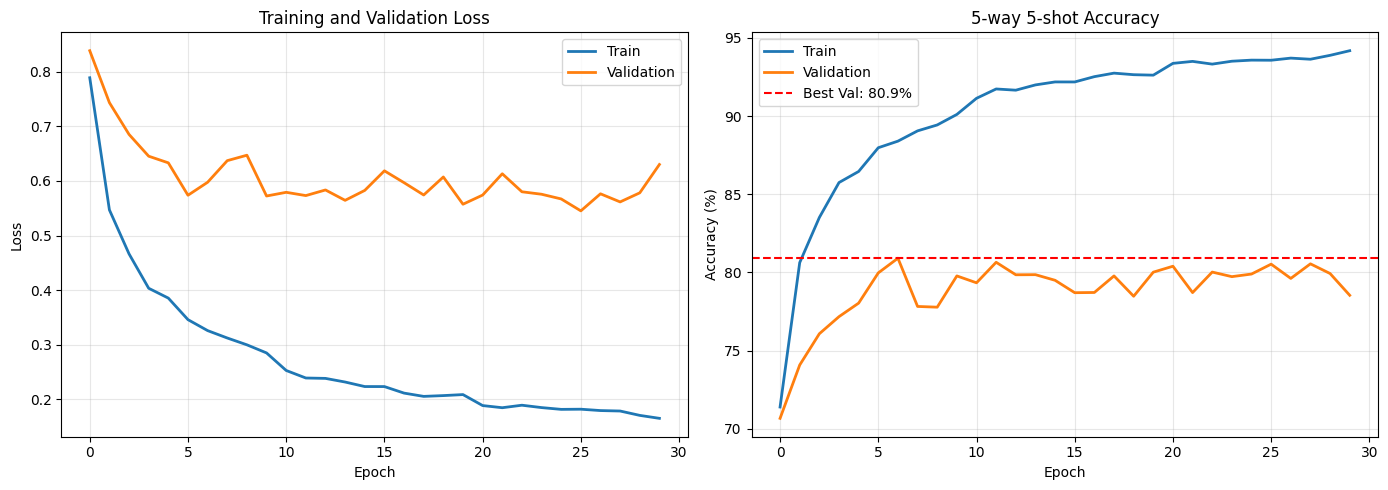

In [46]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(train_losses, label='Train', linewidth=2)
axes[0].plot(val_losses, label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot([a * 100 for a in train_accs], label='Train', linewidth=2)
axes[1].plot([a * 100 for a in val_accs], label='Validation', linewidth=2)
axes[1].axhline(y=best_val_acc * 100, color='r', linestyle='--', label=f'Best Val: {best_val_acc:.1%}')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title(f'{N_WAY}-way {K_SHOT}-shot Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('protonet_training_history.png', dpi=150)
plt.show()


## 7. Testing on Held-out Categories

Test on completely new categories that the model has never seen during training.


In [47]:
# Load best model
checkpoint = torch.load('best_protonet_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch'] + 1}")
print(f"Validation accuracy: {checkpoint['val_acc']:.2%}")


Loaded best model from epoch 7
Validation accuracy: 80.91%


In [ ]:
# Test on held-out categories
def test_few_shot(model, test_category_images, test_categories, n_way, k_shot, q_query, 
                  n_episodes=1000, device=device):
    """
    Test few-shot performance on test categories.
    """
    model.eval()
    
    test_dataset = PrototypicalDataset(
        test_category_images, test_categories, transform=val_transform
    )
    test_sampler = EpisodeSampler(
        test_category_images, test_categories,
        n_way=n_way, k_shot=k_shot, q_query=q_query,
        n_episodes=n_episodes
    )
    test_loader = DataLoader(
        test_dataset,
        batch_sampler=test_sampler,
        num_workers=0
    )
    
    accuracies = []
    
    with torch.no_grad():
        for images, _ in tqdm(test_loader, desc=f'Testing {n_way}-way {k_shot}-shot'):
            images = images.to(device)
            
            support_images, _, query_images, query_labels = split_episode_batch(
                images, None, n_way, k_shot, q_query
            )
            query_labels = query_labels.to(device)
            
            log_probs = model(support_images, query_images, n_way, k_shot)
            preds = log_probs.argmax(dim=1)
            acc = (preds == query_labels).float().mean().item()
            accuracies.append(acc)
    
    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    ci95 = 1.96 * std_acc / np.sqrt(len(accuracies))
    
    return mean_acc, std_acc, ci95, accuracies


def test_few_shot_with_predictions(model, test_category_images, test_categories, n_way, k_shot, q_query, 
                                   n_episodes=500, device=device):
    """
    Test few-shot performance and collect predictions for confusion matrix.
    Returns predictions and true labels mapped to actual category names.
    """
    model.eval()
    
    all_true_categories = []
    all_pred_categories = []
    
    # Set seed for reproducibility
    random.seed(SEED)
    np.random.seed(SEED)
    
    with torch.no_grad():
        for episode in tqdm(range(n_episodes), desc=f'Collecting predictions {n_way}-way {k_shot}-shot'):
            # Sample N classes for this episode (same way EpisodeSampler does)
            episode_classes = random.sample(test_categories, n_way)
            
            # Build episode data
            support_images_list = []
            query_images_list = []
            query_labels_list = []
            
            for class_idx, cat in enumerate(episode_classes):
                # Sample K+Q images for this class
                available_images = random.sample(test_category_images[cat], k_shot + q_query)
                
                # Support set
                for img_path in available_images[:k_shot]:
                    img = Image.open(img_path).convert('L')
                    img_tensor = val_transform(img).unsqueeze(0).to(device)
                    support_images_list.append(img_tensor)
                
                # Query set
                for img_path in available_images[k_shot:]:
                    img = Image.open(img_path).convert('L')
                    img_tensor = val_transform(img).unsqueeze(0).to(device)
                    query_images_list.append(img_tensor)
                    query_labels_list.append(class_idx)
            
            # Stack tensors
            support_images = torch.cat(support_images_list, dim=0)
            query_images = torch.cat(query_images_list, dim=0)
            query_labels = torch.tensor(query_labels_list).to(device)
            
            # Forward pass
            log_probs = model(support_images, query_images, n_way, k_shot)
            preds = log_probs.argmax(dim=1)
            
            # Map episode indices to actual category names
            for true_idx, pred_idx in zip(query_labels.cpu().numpy(), preds.cpu().numpy()):
                all_true_categories.append(episode_classes[true_idx])
                all_pred_categories.append(episode_classes[pred_idx])
    
    return all_true_categories, all_pred_categories


# Test with different shot configurations
print(f"\nTesting on {len(test_categories)} held-out categories:")
print(f"Categories: {test_categories}")
print("\n" + "=" * 60)

test_configs = [
    (5, 1),   # 5-way 1-shot
    (5, 5),   # 5-way 5-shot
]

results = {}
for n_way, k_shot in test_configs:
    if n_way > len(test_categories):
        print(f"Skipping {n_way}-way (only {len(test_categories)} test categories)")
        continue
    
    mean_acc, std_acc, ci95, _ = test_few_shot(
        model, test_category_images, test_categories,
        n_way=n_way, k_shot=k_shot, q_query=Q_QUERY,
        n_episodes=500
    )
    
    results[(n_way, k_shot)] = mean_acc
    print(f"{n_way}-way {k_shot}-shot: {mean_acc:.2%} ± {ci95:.2%}")



Testing on 9 held-out categories:
Categories: ['The Eiffel Tower', 'ambulance', 'asparagus', 'calculator', 'broccoli', 'airplane', 'ant', 'barn', 'bush']



Testing 5-way 1-shot: 100%|██████████| 500/500 [00:28<00:00, 17.43it/s]


5-way 1-shot: 63.99% ± 0.88%


Testing 5-way 5-shot: 100%|██████████| 500/500 [00:42<00:00, 11.83it/s]

5-way 5-shot: 81.23% ± 0.66%



Generating Confusion Matrix...



Overall Accuracy: 81.50%
Total predictions: 37500


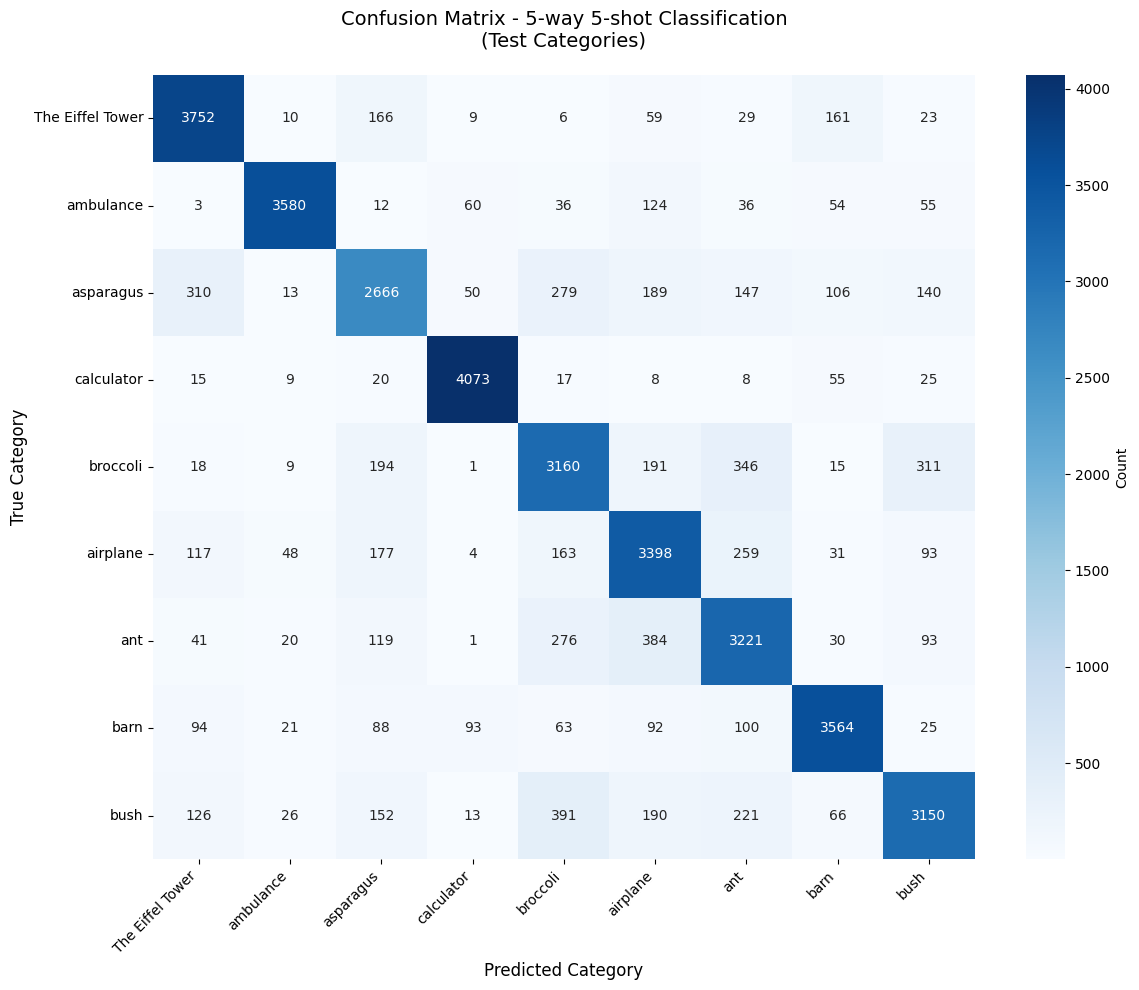


Classification Report:
                  precision    recall  f1-score   support

The Eiffel Tower      0.838     0.890     0.863      4215
       ambulance      0.733     0.792     0.761      4290
       asparagus      0.958     0.904     0.930      3960
      calculator      0.738     0.770     0.753      4185
        broccoli      0.742     0.684     0.712      3900
        airplane      0.873     0.861     0.867      4140
             ant      0.720     0.744     0.732      4245
            barn      0.805     0.727     0.764      4335
            bush      0.946     0.963     0.955      4230

        accuracy                          0.815     37500
       macro avg      0.817     0.815     0.815     37500
    weighted avg      0.816     0.815     0.815     37500



In [57]:
# Generate confusion matrix for test results
print("\n" + "=" * 60)
print("Generating Confusion Matrix...")
print("=" * 60)

# Use 5-way 5-shot for confusion matrix (best performing configuration)
n_way_cm = 5
k_shot_cm = 5

# Collect predictions
true_categories, pred_categories = test_few_shot_with_predictions(
    model, test_category_images, test_categories,
    n_way=n_way_cm, k_shot=k_shot_cm, q_query=Q_QUERY,
    n_episodes=500, device=device
)

# Create confusion matrix
cm = confusion_matrix(true_categories, pred_categories, labels=test_categories)

# Calculate accuracy
accuracy = accuracy_score(true_categories, pred_categories)
print(f"\nOverall Accuracy: {accuracy:.2%}")
print(f"Total predictions: {len(true_categories)}")

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_categories, yticklabels=test_categories,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {n_way_cm}-way {k_shot_cm}-shot Classification\n(Test Categories)', 
          fontsize=14, pad=20)
plt.xlabel('Predicted Category', fontsize=12)
plt.ylabel('True Category', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('protonet_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Print classification report
print("\n" + "=" * 60)
print("Classification Report:")
print("=" * 60)
print(classification_report(true_categories, pred_categories, 
                            target_names=test_categories, digits=3))


## 8. Visualize Embeddings with t-SNE


In [58]:
def get_embeddings(model, category_images, categories, transform, device, samples_per_class=50):
    """
    Get embeddings for visualization.
    """
    model.eval()
    embeddings = []
    labels = []
    
    with torch.no_grad():
        for cat_idx, cat in enumerate(categories):
            sample_paths = random.sample(
                category_images[cat], 
                min(samples_per_class, len(category_images[cat]))
            )
            
            for img_path in sample_paths:
                img = Image.open(img_path).convert('L')
                img_tensor = transform(img).unsqueeze(0).to(device)
                
                embedding = model.get_embedding(img_tensor)
                embeddings.append(embedding.cpu().numpy())
                labels.append(cat)
    
    return np.vstack(embeddings), labels


# Get embeddings for test categories
print("Computing embeddings for t-SNE visualization...")
test_embeddings, test_labels = get_embeddings(
    model, test_category_images, test_categories,
    val_transform, device, samples_per_class=50
)

print(f"Embedding shape: {test_embeddings.shape}")
print(f"Number of labels: {len(test_labels)}")


Computing embeddings for t-SNE visualization...
Embedding shape: (450, 64)
Number of labels: 450


Applying t-SNE...


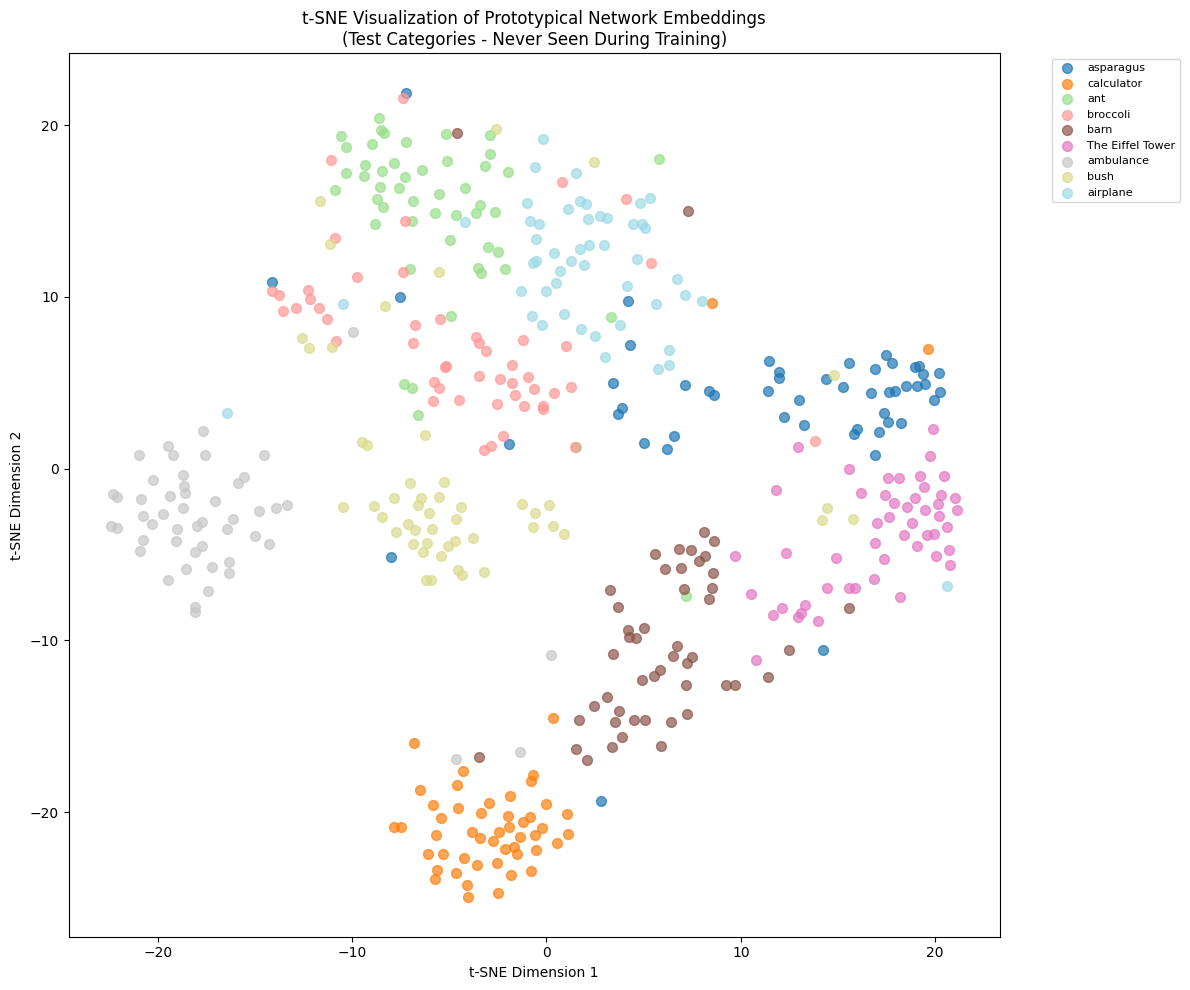

In [59]:
# Apply t-SNE
print("Applying t-SNE...")
tsne = TSNE(n_components=2, random_state=SEED, perplexity=30, max_iter=1000)
embeddings_2d = tsne.fit_transform(test_embeddings)

# Plot
plt.figure(figsize=(12, 10))

unique_labels = list(set(test_labels))
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

for i, label in enumerate(unique_labels):
    mask = np.array(test_labels) == label
    plt.scatter(
        embeddings_2d[mask, 0],
        embeddings_2d[mask, 1],
        c=[colors[i]],
        label=label,
        alpha=0.7,
        s=50
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.title('t-SNE Visualization of Prototypical Network Embeddings\n(Test Categories - Never Seen During Training)', fontsize=12)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.tight_layout()
plt.savefig('protonet_embeddings_tsne.png', dpi=150, bbox_inches='tight')
plt.show()


## 9. Interactive Few-Shot Classification Demo


In [60]:
def few_shot_classify(model, support_images_dict, query_image_path, transform, device):
    """
    Classify a query image given support examples for each class.
    
    Args:
        model: trained ProtoNet model
        support_images_dict: dict of class_name -> list of image paths
        query_image_path: path to query image
        transform: image transform
        device: torch device
    
    Returns:
        predicted_class, class_probabilities
    """
    model.eval()
    
    class_names = list(support_images_dict.keys())
    n_way = len(class_names)
    
    with torch.no_grad():
        # Compute prototypes for each class
        prototypes = []
        for class_name in class_names:
            class_embeddings = []
            for img_path in support_images_dict[class_name]:
                img = Image.open(img_path).convert('L')
                img_tensor = transform(img).unsqueeze(0).to(device)
                embedding = model.get_embedding(img_tensor)
                class_embeddings.append(embedding)
            
            # Mean embedding as prototype
            prototype = torch.stack(class_embeddings).mean(dim=0)
            prototypes.append(prototype)
        
        prototypes = torch.cat(prototypes, dim=0)  # [n_way, embedding_dim]
        
        # Encode query
        query_img = Image.open(query_image_path).convert('L')
        query_tensor = transform(query_img).unsqueeze(0).to(device)
        query_embedding = model.get_embedding(query_tensor)
        
        # Compute distances
        distances = model.compute_distances(query_embedding, prototypes)
        
        # Softmax to get probabilities
        probs = F.softmax(-distances, dim=1).squeeze().cpu().numpy()
        
        predicted_idx = np.argmax(probs)
        predicted_class = class_names[predicted_idx]
    
    return predicted_class, dict(zip(class_names, probs))


# Demo: classify random query images
def demo_few_shot_classification(n_classes=5, k_shot=3):
    """Demo few-shot classification with random samples"""
    # Sample random classes from test set
    demo_classes = random.sample(test_categories, min(n_classes, len(test_categories)))
    
    # Build support set
    support_images_dict = {}
    query_pool = {}
    
    for cls in demo_classes:
        all_images = list(test_category_images[cls])
        random.shuffle(all_images)
        support_images_dict[cls] = all_images[:k_shot]
        query_pool[cls] = all_images[k_shot:k_shot + 5]
    
    # Classify some queries
    print(f"\n{n_classes}-way {k_shot}-shot Classification Demo")
    print("=" * 50)
    print(f"Classes: {demo_classes}")
    print("\nClassifying random query images...")
    
    correct = 0
    total = 3
    
    for i in range(total):
        true_class = random.choice(demo_classes)
        query_path = random.choice(query_pool[true_class])
        
        pred_class, probs = few_shot_classify(
            model, support_images_dict, query_path, val_transform, device
        )
        
        is_correct = pred_class == true_class
        correct += int(is_correct)
        
        print(f"\nQuery {i+1}: True={true_class}, Predicted={pred_class} {'✓' if is_correct else '✗'}")
        print(f"  Probabilities: {', '.join([f'{k}:{v:.1%}' for k,v in sorted(probs.items(), key=lambda x:-x[1])[:3]])}")
    
    print(f"\nDemo accuracy: {correct}/{total} = {correct/total:.0%}")

demo_few_shot_classification()



5-way 3-shot Classification Demo
Classes: ['ant', 'asparagus', 'barn', 'The Eiffel Tower', 'ambulance']

Classifying random query images...

Query 1: True=The Eiffel Tower, Predicted=barn ✗
  Probabilities: barn:51.2%, The Eiffel Tower:26.1%, asparagus:22.7%

Query 2: True=ant, Predicted=ant ✓
  Probabilities: ant:99.9%, asparagus:0.1%, The Eiffel Tower:0.0%

Query 3: True=asparagus, Predicted=asparagus ✓
  Probabilities: asparagus:55.1%, The Eiffel Tower:44.4%, ant:0.4%

Demo accuracy: 2/3 = 67%


## 10. Save Model for App Integration


In [61]:
# Save model info for app integration
model_info = {
    'model_type': 'PrototypicalNetwork',
    'approach': 'few-shot learning with image matching',
    'embedding_dim': EMBEDDING_DIM,
    'img_size': IMG_SIZE,
    'distance_metric': DISTANCE,
    'n_way': N_WAY,
    'k_shot': K_SHOT,
    'best_val_accuracy': float(best_val_acc),
    'train_categories': train_categories,
    'test_categories': test_categories,
    'num_epochs': NUM_EPOCHS
}

with open('protonet_model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)

print("Model info saved to protonet_model_info.json")
print(f"\nModel Summary:")
print(f"  Type: {model_info['model_type']}")
print(f"  Approach: {model_info['approach']}")
print(f"  Best validation accuracy: {model_info['best_val_accuracy']:.2%}")
print(f"  Distance metric: {model_info['distance_metric']}")


Model info saved to protonet_model_info.json

Model Summary:
  Type: PrototypicalNetwork
  Approach: few-shot learning with image matching
  Best validation accuracy: 80.91%
  Distance metric: euclidean


In [62]:
# Export embeddings for a subset of categories (for app usage)
def create_reference_embeddings(model, category_images, categories, transform, device, 
                                 samples_per_class=10):
    """
    Create reference embeddings for each category.
    These can be used for fast inference in the app.
    """
    model.eval()
    reference_embeddings = {}
    
    with torch.no_grad():
        for cat in tqdm(categories, desc="Creating reference embeddings"):
            sample_paths = random.sample(
                category_images[cat], 
                min(samples_per_class, len(category_images[cat]))
            )
            
            cat_embeddings = []
            for img_path in sample_paths:
                img = Image.open(img_path).convert('L')
                img_tensor = transform(img).unsqueeze(0).to(device)
                embedding = model.get_embedding(img_tensor)
                cat_embeddings.append(embedding.cpu().numpy())
            
            # Store mean embedding as prototype
            reference_embeddings[cat] = np.mean(cat_embeddings, axis=0).squeeze().tolist()
    
    return reference_embeddings

# Create and save reference embeddings
print("\nCreating reference embeddings for all categories...")
all_category_images = {**train_category_images, **val_category_images, **test_category_images}
all_categories = train_categories + val_categories + test_categories

reference_embeddings = create_reference_embeddings(
    model, all_category_images, all_categories, 
    val_transform, device, samples_per_class=20
)

# Save embeddings
with open('protonet_reference_embeddings.json', 'w') as f:
    json.dump(reference_embeddings, f)

print(f"\nSaved reference embeddings for {len(reference_embeddings)} categories")
print("These can be used for fast classification in production.")



Creating reference embeddings for all categories...


Creating reference embeddings: 100%|██████████| 60/60 [00:02<00:00, 23.37it/s]


Saved reference embeddings for 60 categories
These can be used for fast classification in production.


## Summary

### Key Takeaways:

1. **Prototypical Networks** learn a metric space where classification is performed by computing distances to class prototypes.

2. **Episode-based training** simulates few-shot scenarios during training, leading to better generalization.

3. **Meta-learning** enables recognition of completely new categories with just a few examples.

### Advantages over Standard Classification:
- No retraining needed for new categories
- Works with very few examples (1-5 shots)
- Interpretable (based on similarity/distance)

### Advantages over Siamese Networks:
- More efficient at test time (compare to prototypes, not all pairs)
- Better utilizes multiple support examples
- Cleaner training objective

### Files Generated:
- `best_protonet_model.pth` - Trained model weights
- `protonet_model_info.json` - Model configuration
- `protonet_reference_embeddings.json` - Pre-computed class prototypes
- `protonet_training_history.png` - Training curves
- `protonet_embeddings_tsne.png` - Embedding visualization


## 9. Interactive Few-Shot Classification Demo


In [63]:
# Optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

print(f"Optimizer: Adam with lr={LEARNING_RATE}")
print(f"Scheduler: StepLR (decay every 10 epochs)")


Optimizer: Adam with lr=0.001
Scheduler: StepLR (decay every 10 epochs)
